Dataset Link: https://www.kaggle.com/venkateshroshan/traffic-signs

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d venkateshroshan/traffic-signs

 98% 301M/308M [00:03<00:00, 76.8MB/s]
100% 308M/308M [00:03<00:00, 92.5MB/s]


In [ ]:
!unzip *.zip && rm -rf *.zip

In [ ]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
batch_size = 32
img_height = 30
img_width = 30

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/Traffic Signs/Train",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  validation_split=0.2,
  subset="training")

Found 39209 files belonging to 43 classes.
Using 31368 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/Traffic Signs/Train",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  validation_split=0.2,
  subset="validation")

Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes =len(class_names)
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [ ]:
import pandas as pd

labels = pd.read_csv("/content/Traffic Signs/Labels.csv")
value = labels['SignName'][labels['ClassId'] == int(class_names[5])].values[0]

In [ ]:
value

'Yield'

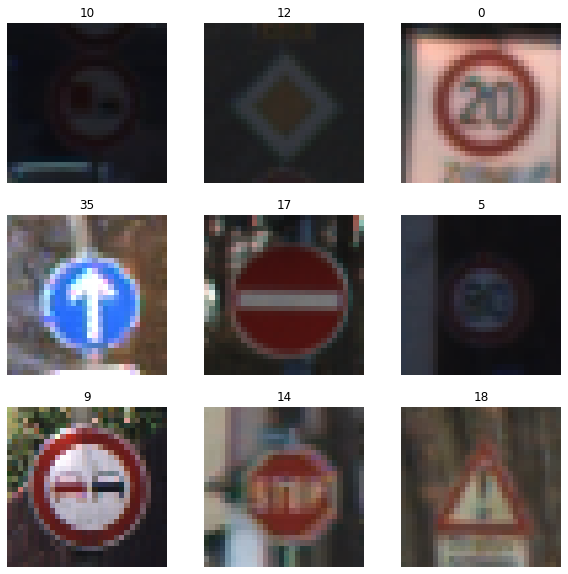

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1000, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
num_classes

43

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("signs.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

In [ ]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/100
981/981 [==============================] - 45s 7ms/step - loss: 2.1398 - accuracy: 0.3481 - val_loss: 1.3107 - val_accuracy: 0.5595

Epoch 00001: val_loss improved from inf to 1.31074, saving model to signs.h5
Epoch 2/100
981/981 [==============================] - 5s 5ms/step - loss: 1.0661 - accuracy: 0.6341 - val_loss: 0.6143 - val_accuracy: 0.7848

Epoch 00002: val_loss improved from 1.31074 to 0.61430, saving model to signs.h5
Epoch 3/100
981/981 [==============================] - 5s 5ms/step - loss: 0.7028 - accuracy: 0.7577 - val_loss: 0.4094 - val_accuracy: 0.8615

Epoch 00003: val_loss improved from 0.61430 to 0.40943, saving model to signs.h5
Epoch 4/100
981/981 [==============================] - 5s 5ms/step - loss: 0.5504 - accuracy: 0.8131 - val_loss: 0.3636 - val_accuracy: 0.8703

Epoch 00004: val_loss improved from 0.40943 to 0.36364, saving model to signs.h5
Epoch 5/100
981/981 [==============================] - 5s 5ms/step - loss: 0.4593 - accuracy: 0.8439 - 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

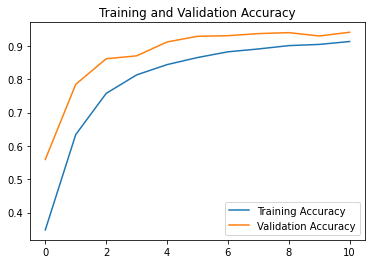

In [ ]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

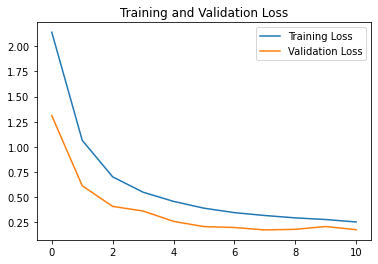

In [ ]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/signs.h5" "/content/drive/MyDrive"